# Decaying network (parrot neurons)


- a network of 100 excitatory cells without any recurrent connections and inhibitions

## define fileName, saving path and libraries

In [1]:
# fileName

fileName = 'eg_decaying-network' 

In [6]:
try:
    import pyNN.spiNNaker as sim
except ModuleNotFoundError:
    import pyNN.brian2 as sim
    
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pickle
import pandas as pd
import seaborn as sns
import time
import datetime
import json
import warnings
warnings.filterwarnings('ignore')
import python_utils as pu
%matplotlib inline

savePath = f'../outputs/' # remember to create the folder if not already present (mkdir ./notebooks/outputs)
dt_string = datetime.datetime.today().isoformat() # ISO8601 ! :-)
tag = dt_string 
saveName = f'{savePath}{fileName}-{tag}'
print(saveName)
PARS={}


../outputs/eg_decaying-network-2023-11-23T19:23:55.371493


## simulations settings

In [17]:
sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 #ms

2023-11-23 19:29:35 INFO: Read cfg files: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/bbpnrsoa/.spynnaker.cfg
2023-11-23 19:29:35 INFO: Will search these locations for binaries: /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/common_model_binaries : /home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/model_binaries
2023-11-23 19:29:35 INFO: Setting time scale factor to 10.
2023-11-23 19:29:35 INFO: Setting machine time step to 1000 micro-seconds.


['/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/bbpnrsoa/sPyNNaker/lib/python3.8/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/bbpnrsoa/.spynnaker.cfg']


## network design

In [18]:
pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['network']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 


## input design

array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

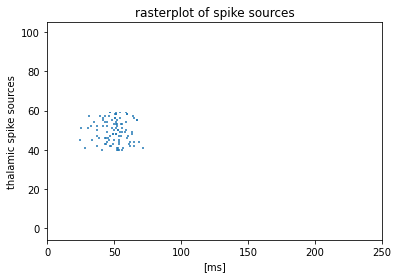

In [7]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['network']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source
#random_sources_idx = [np.random.randint(n_cells[popName]*0.40, n_cells[popName]*0.60) for i in range(n_cells[popName])]
random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

neuron_Model[popName] = sim.SpikeSourceArray(spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                               label = popName)

proj = {}
proj['Thalamus', 'network'] = sim.Projection(pops['Thalamus'], 
                                         pops['network'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         space = space.Space(axes = 'x'),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-network connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

## run the simulations

In [8]:
tic = time.time()
sim.run(simtime)
toc = time.time() - tic

2023-11-23 19:24:07 INFO: Starting execution process
2023-11-23 19:24:07 INFO: Simulating for 250 1.0ms timesteps using a hardware timestep of 10000us
Adding Splitter selectors where appropriate
|0%                          50%                         100%|
2023-11-23 19:24:07 INFO: Time 0:00:00.014084 taken by SpynnakerSplitterSelector
Adding delay extensions as required
|0%                          50%                         100%|
2023-11-23 19:24:07 INFO: Time 0:00:00.011681 taken by DelaySupportAdder
2023-11-23 19:24:10 INFO: Time 0:00:03.114621 taken by SpallocMaxMachineGenerator
Preallocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2023-11-23 19:24:23 INFO: Time 0:00:12.610364 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2023-11-

## save and recover stateVars

In [10]:
stateVars = {}
for pop in pops.keys():
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[pop].write_data(f'{saveName}-{recording}.pkl')
        stateVars[pop]=pops[pop].get_data()

stateVars.keys()
results = pu.recover_results(stateVars)
results.keys()

Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_inh for network
|0%                          50%                         100%|
Getting spikes for network
|0%                          50%                         100%|
Getting v for network
|0%                          50%                         100%|
Getting gsyn_exc for network
|0%                          50%                         100%|
Getting gsyn_in

network
v
gsyn_exc
gsyn_inh
Thalamus


dict_keys([('network', 'v'), ('network', 'gsyn_exc'), ('network', 'gsyn_inh'), ('network', 'spikes'), ('Thalamus', 'spikes')])

## postprocessing

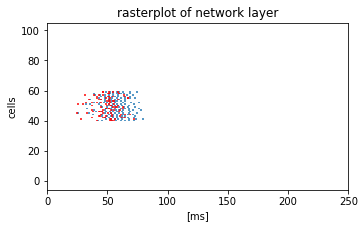

In [11]:
# check the spikes

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['network']):
    axes_list[idx].eventplot(results[value, 'spikes'])
    axes_list[idx].eventplot(spike_times, color='r')
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)


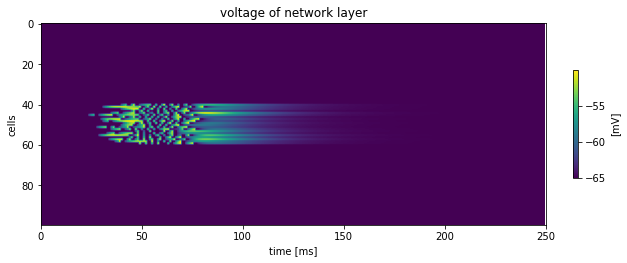

In [12]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

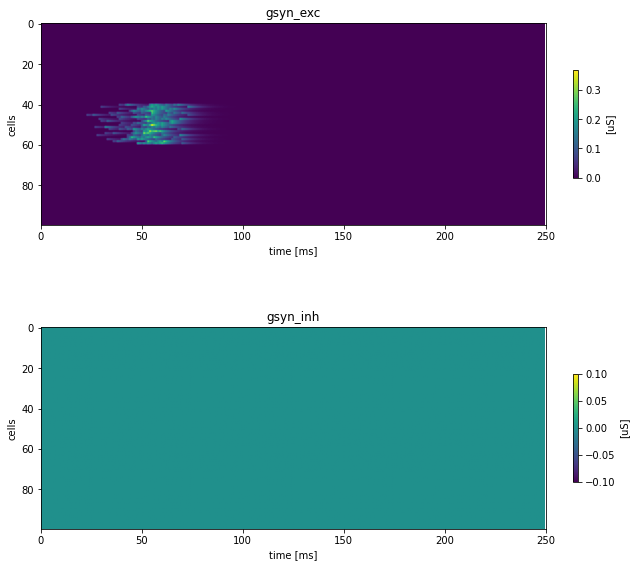

In [13]:
# check the conductances

# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results['network', gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        axes_list[idx].set_xlim(0, simtime)
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

## end simulation

In [16]:
sim.end()

# remember that if you end the simulation, 
# than some PyNN routines are not working anymore, 
# so close only at the very end of your analysis

2023-11-23 19:28:16 ERROR: Ignoring call to stop/end as no simulator running
